In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import missingno as msn
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.compose import make_column_selector, make_column_transformer
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_excel("./2_5301182359977087197.xlsx")

In [17]:
df.set_index('customer_id', inplace=True)

In [18]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [19]:
df.isnull().sum()


credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [21]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<AxesSubplot:>

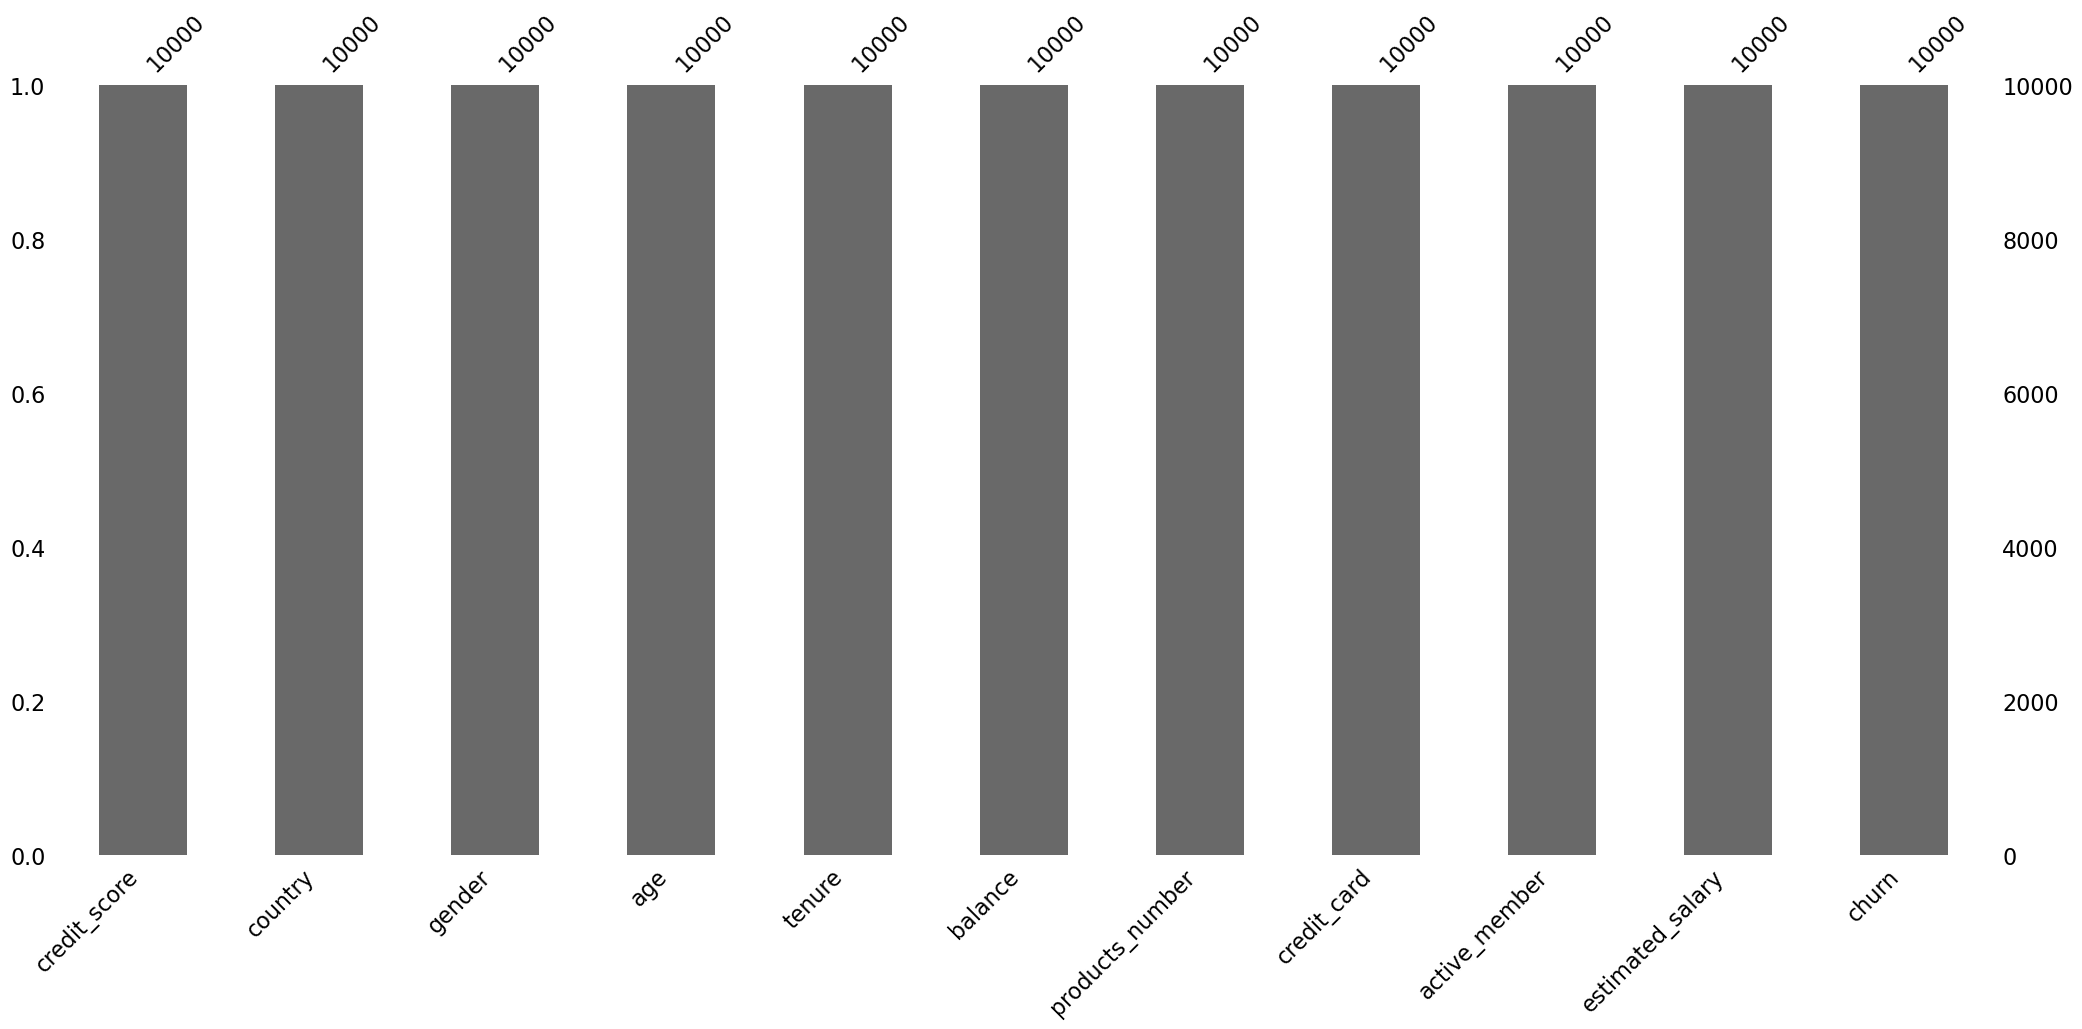

In [22]:
import missingno as msno
msno.bar(df)

### Sturges formula for bin size

In [23]:
bin_size= round(1 + 3.322*math.log(df.shape[0]))
print(bin_size)

32


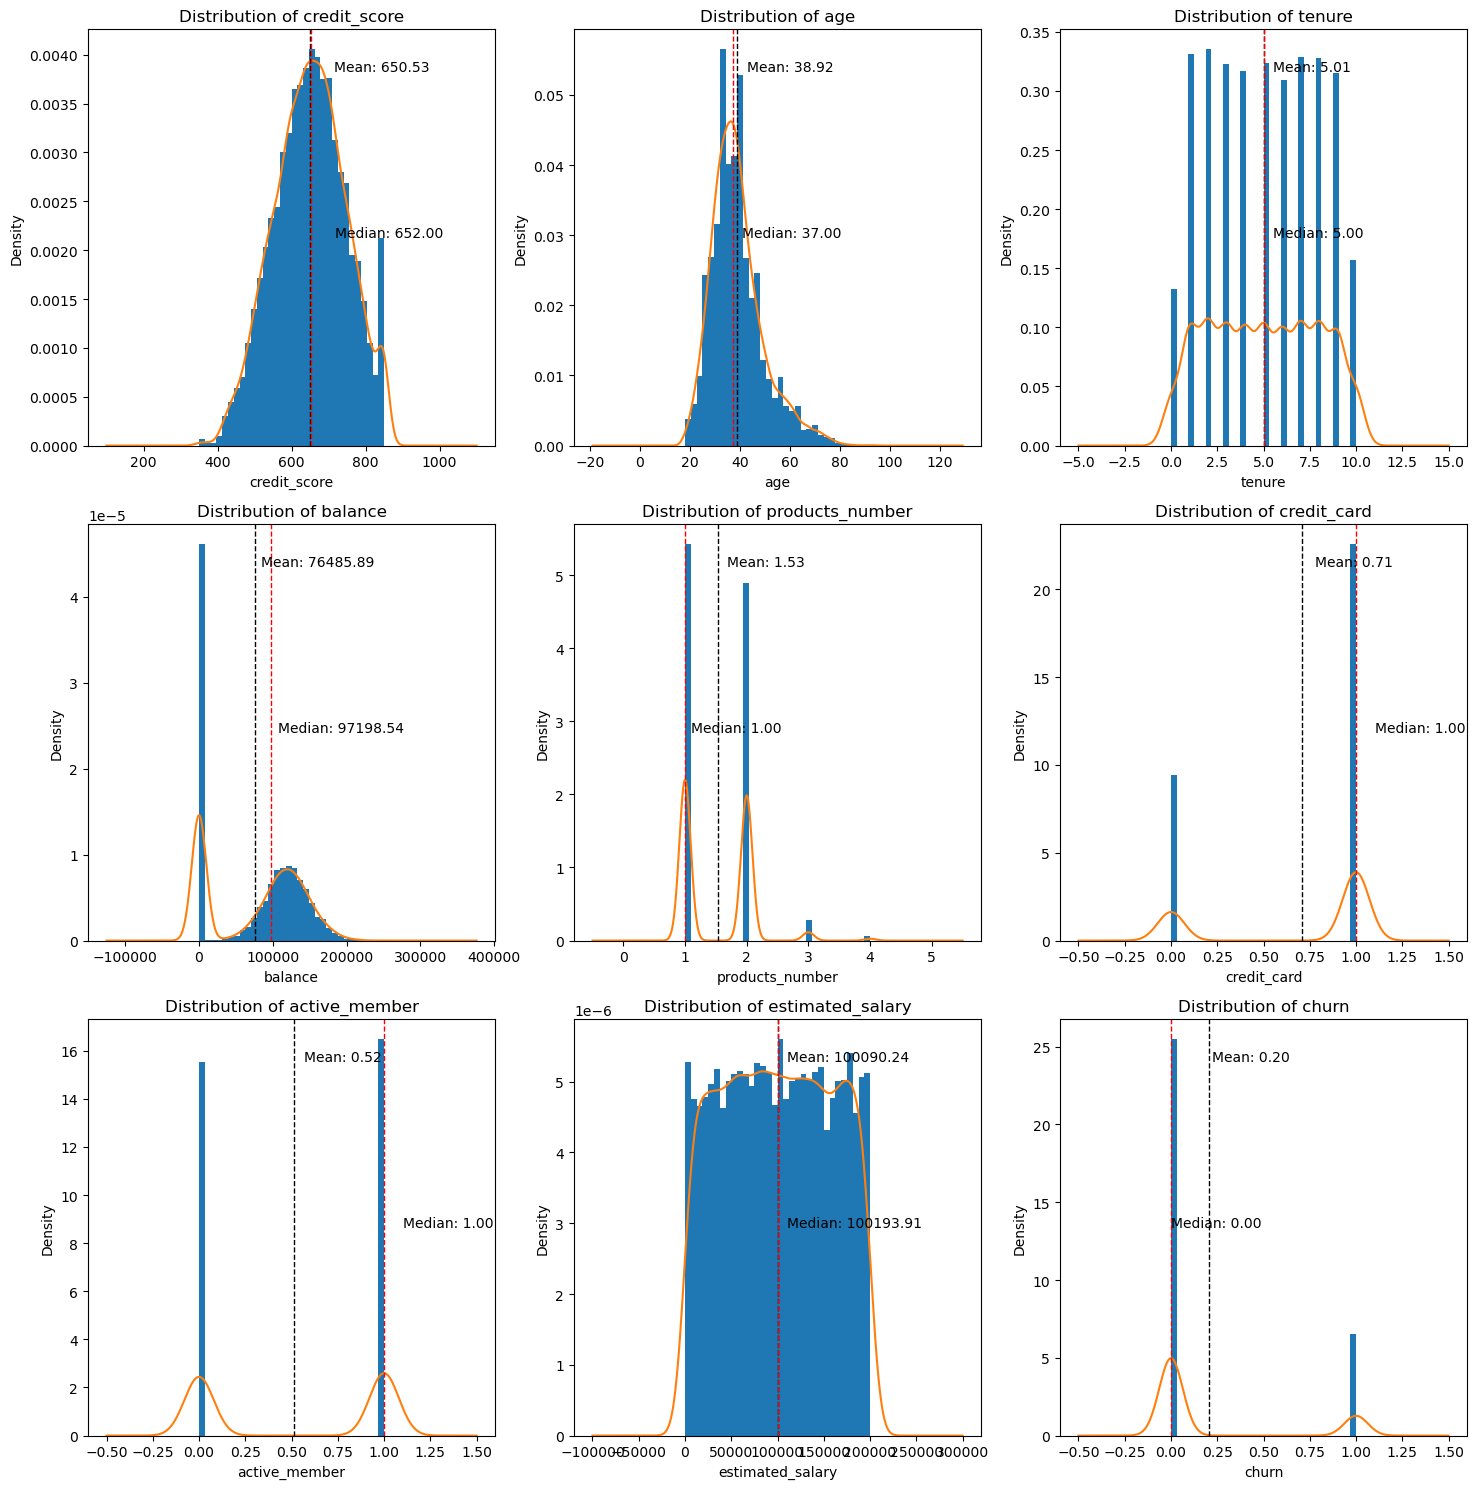

In [24]:
num_features = [i for i in df.columns if df[i].dtypes != 'object']

fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 

axes = axes.flatten()

# Iterate over each numerical feature and plot
for i, cols in enumerate(num_features):
    
    ax = axes[i]
    
    df[cols].plot(kind='hist', density=True, bins=bin_size, ax=ax)
    df[cols].plot(kind='kde', ax=ax)
    
    
    ax.axvline(df[cols].mean(), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(df[cols].median(), color='r', linestyle='dashed', linewidth=1)  # median with different color
    
    
    min_ylim, max_ylim = ax.get_ylim()
    ax.text(df[cols].mean() * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(df[cols].mean()))
    ax.text(df[cols].median() * 1.1, max_ylim * 0.5, 'Median: {:.2f}'.format(df[cols].median()))
    
    
    ax.set_xlabel(cols)
    ax.set_title(f"Distribution of {cols}")


plt.tight_layout()
plt.show()

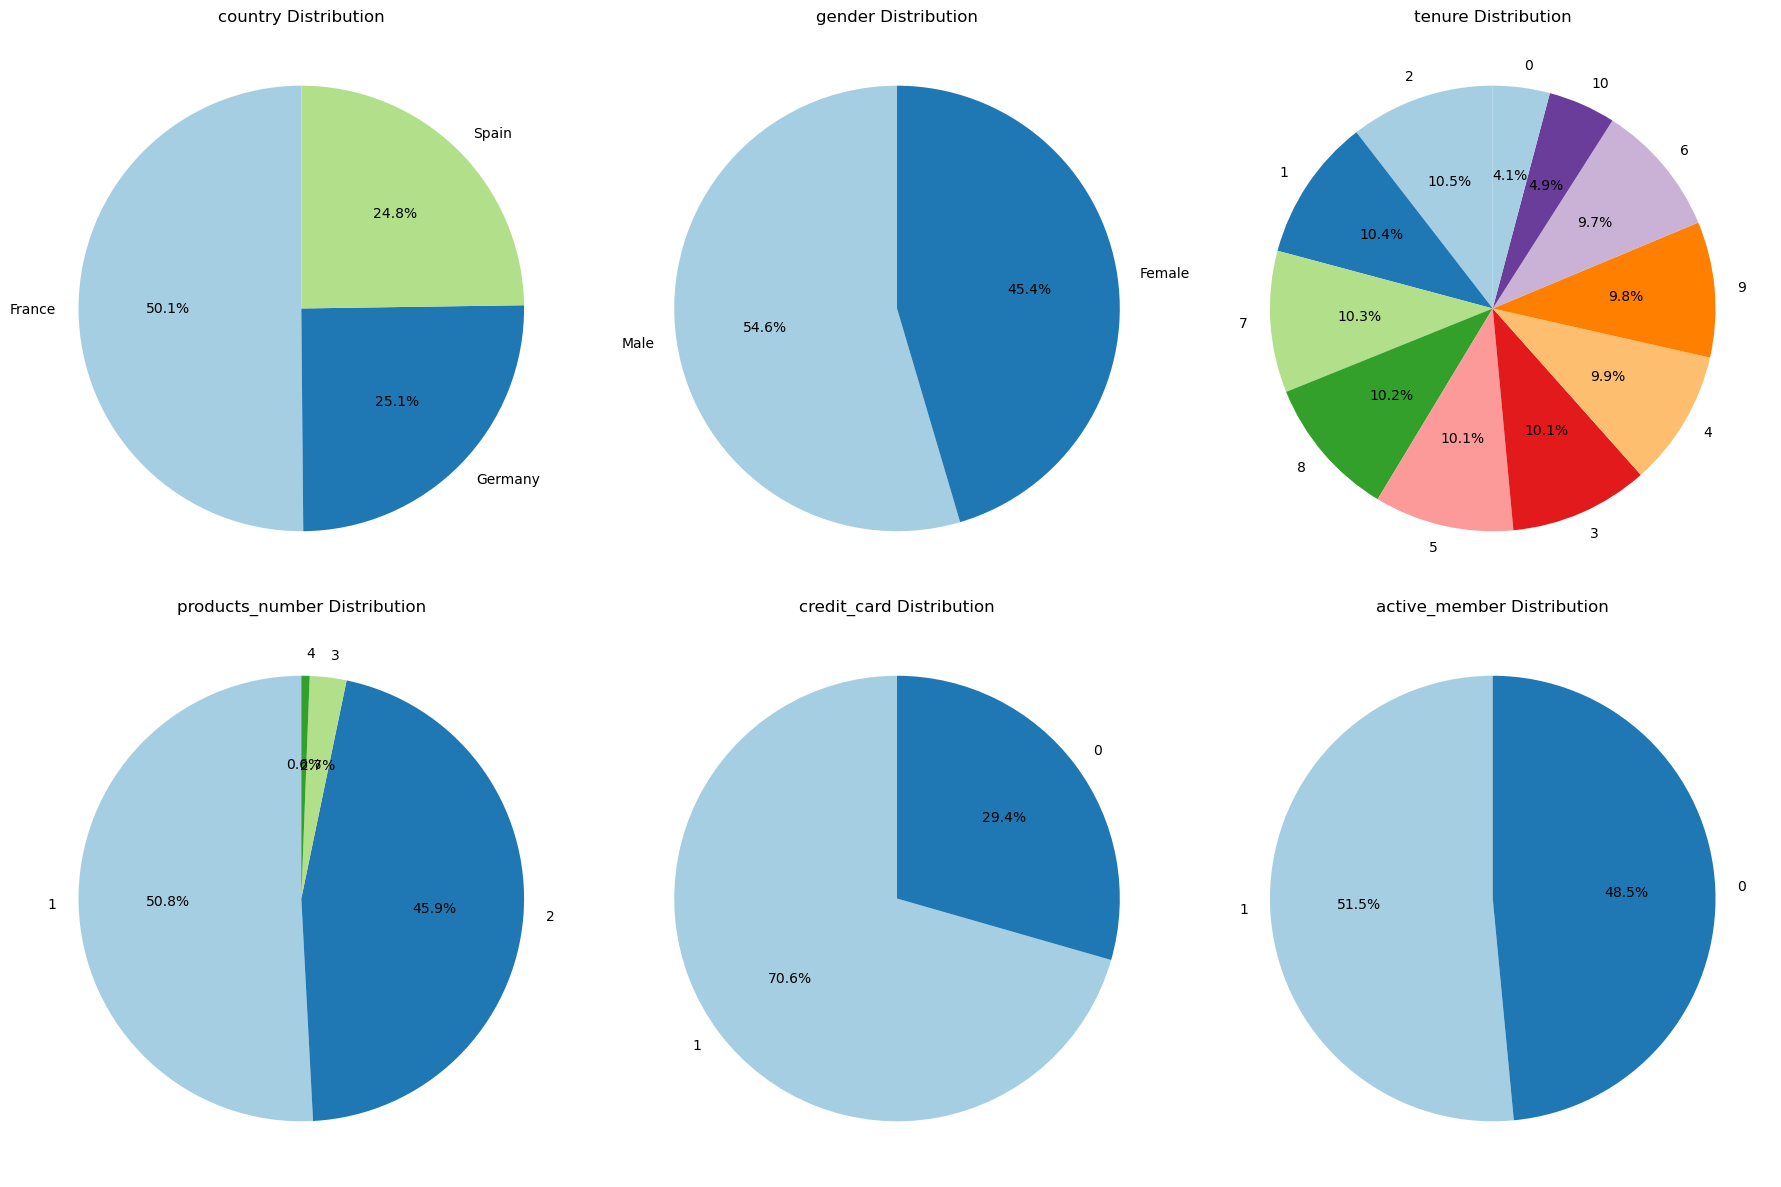

In [25]:
columns_to_plot = ['country', 'gender', 'tenure', 'products_number', 'credit_card', 'active_member']

fig, axs = plt.subplots(2, 3, figsize=(18, 12))


colors = plt.cm.Paired(range(10))


for ax, col in zip(axs.flatten(), columns_to_plot):
    
    value_counts = df[col].value_counts(normalize=True) * 100

    # Plot pie chart on the current axis
    ax.pie(value_counts, labels=value_counts.index, autopct=lambda pct: f'{pct:.1f}%', colors=colors, startangle=90)
    ax.set_title(f'{col} Distribution') 

plt.tight_layout()
plt.show()

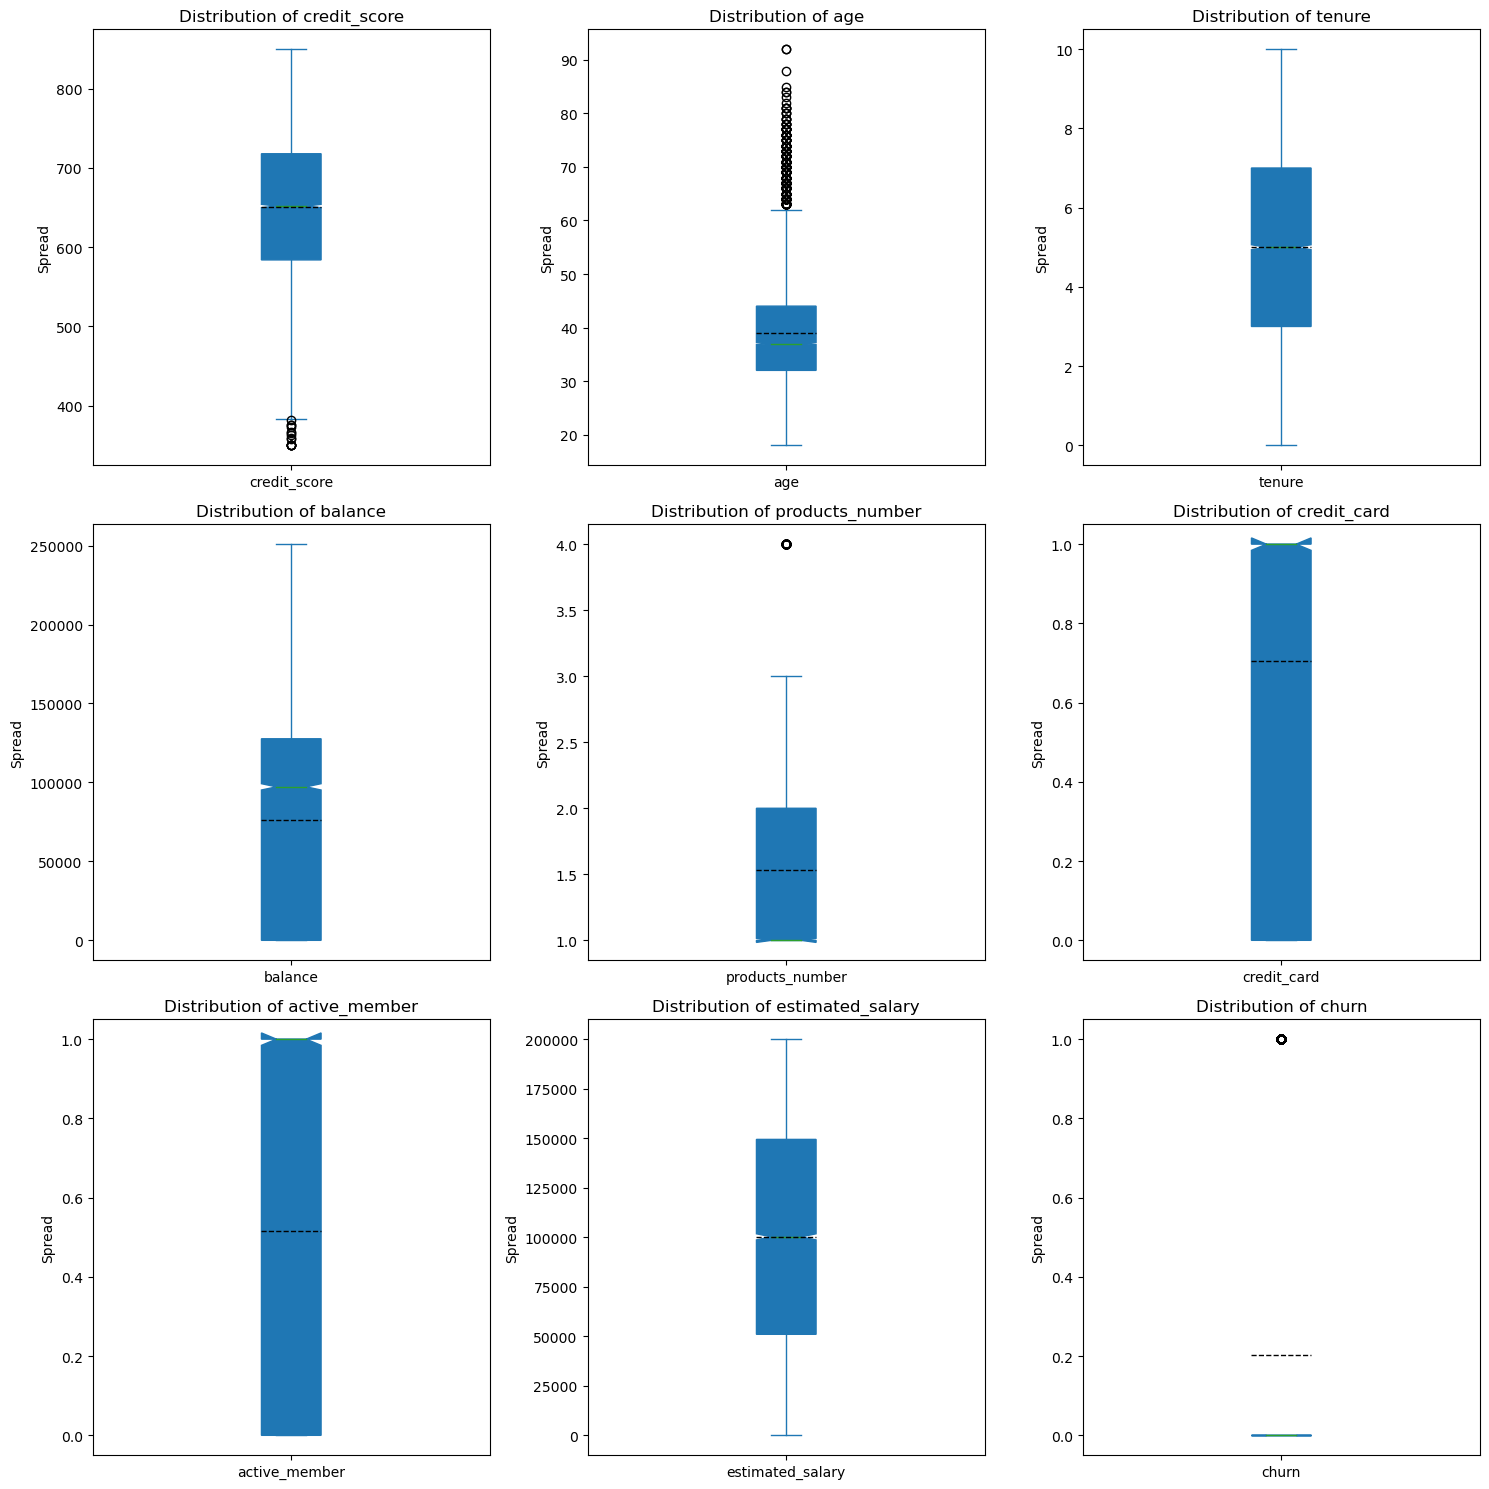

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i,cols in enumerate(num_features):
    ax = axes[i]
    df[cols].plot(kind='box', notch=True, patch_artist=True, meanline=True, showmeans=True, meanprops=dict(color='black'),ax=ax)
    
    ax.set_ylabel('Spread')
    
    ax.set_title(f"Distribution of {cols}")
    
plt.tight_layout()
plt.show()


 ### Imbalance problem

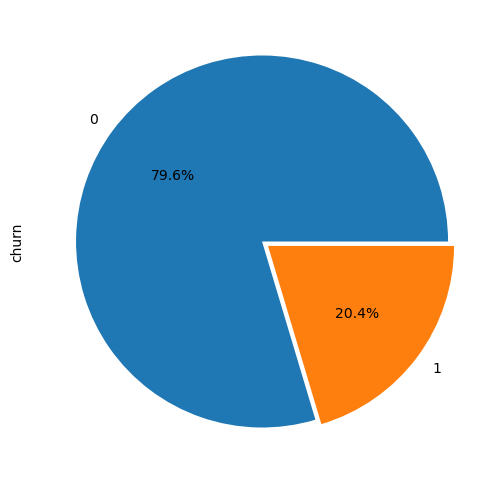

In [27]:
fig,ax=plt.subplots(figsize=(6,8))
explode=[0,0.04]
ax=(df["churn"].value_counts(normalize=True)*100).plot.pie(explode=explode,autopct="%.1f%%")

### EDA

In [28]:
df_eda=df.copy()

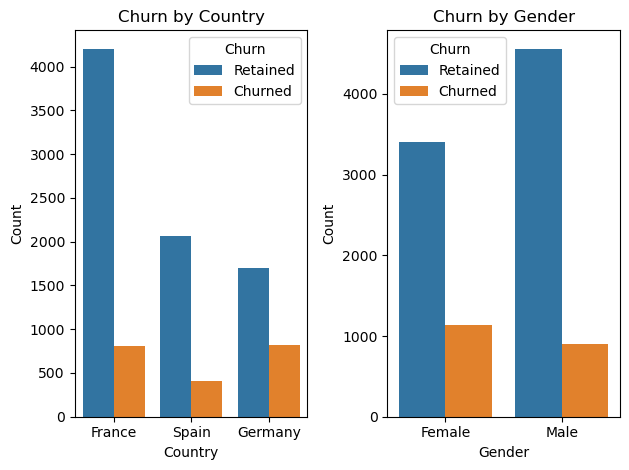

In [29]:
plt.subplot(1, 2, 1)  
sns.countplot(x='country', hue='churn', data=df)
plt.title('Churn by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Retained', 'Churned'])

plt.subplot(1, 2, 2) 
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Retained', 'Churned'])

plt.tight_layout() 
plt.show()

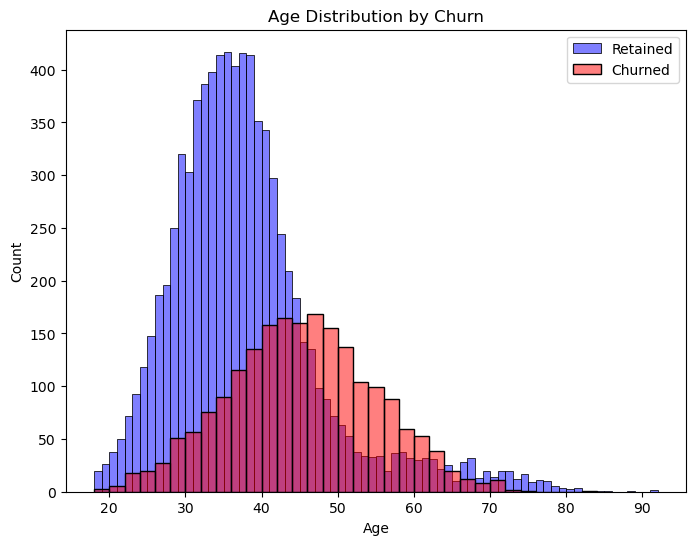

In [30]:

plt.figure(figsize=(8, 6))
sns.histplot(df[df['churn'] == 0]['age'], color='blue', alpha=0.5, label='Retained')
sns.histplot(df[df['churn'] == 1]['age'], color='red', alpha=0.5, label='Churned')
plt.title('Age Distribution by Churn')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


As we see young generation still use service but old generation tend to more churn.


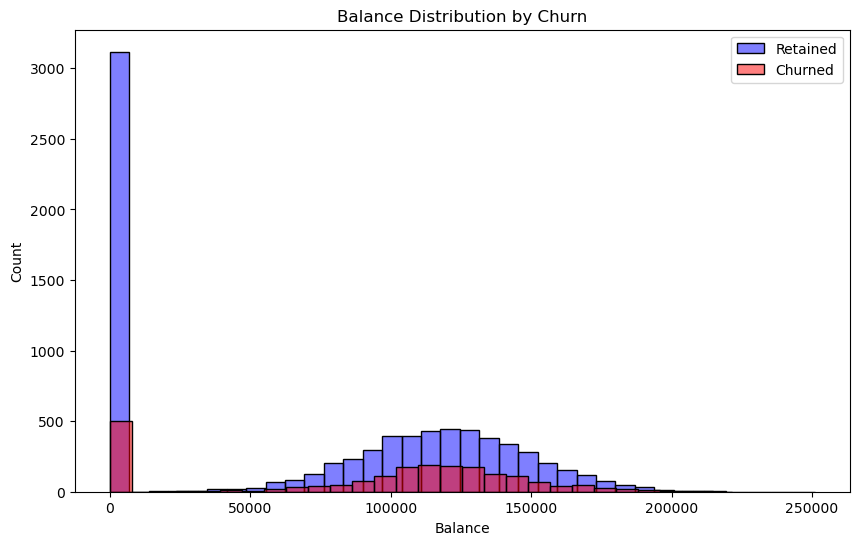

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['churn'] == 0]['balance'], color='blue', alpha=0.5, label='Retained', bins=32)
sns.histplot(df[df['churn'] == 1]['balance'], color='red', alpha=0.5, label='Churned', bins=32)
plt.title('Balance Distribution by Churn')
plt.xlabel('Balance')
plt.ylabel('Count')
plt.legend()
plt.show()

Some people with zero balance retained still using services may be they just opened and forget to churn.

In [32]:
df.loc[df["balance"]==0,['churn']].value_counts()

churn
0        3117
1         500
dtype: int64

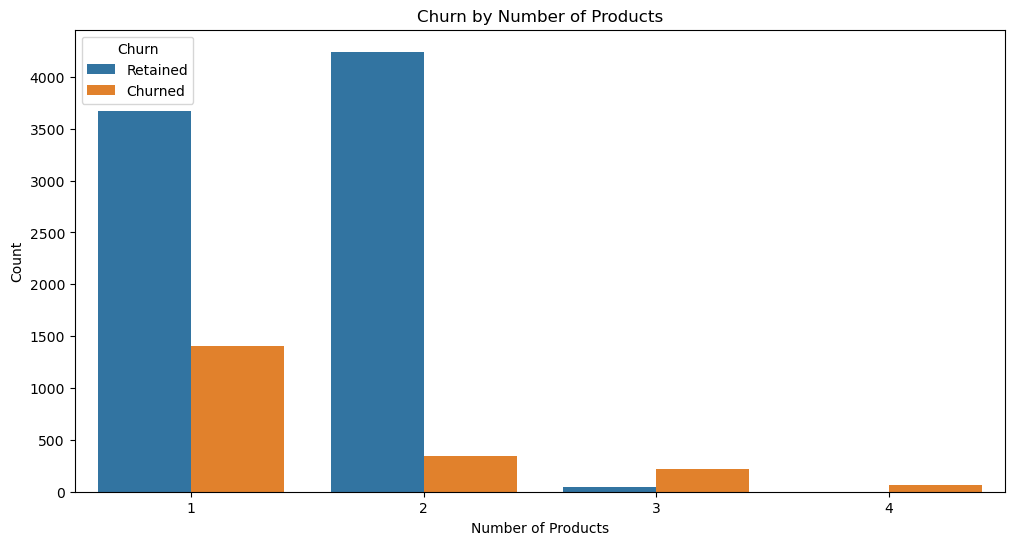

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(x='products_number', hue='churn', data=df)
plt.title('Churn by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Retained', 'Churned'])
plt.show()

In [34]:

bins = [df_eda['age'].min(), 28,36,44,52,60,68,df_eda['age'].max()]
labels = ['age_1','age_2','age_3','age_4','age_5','age_6','age_7']
df_eda['age_group'] = pd.cut(df_eda['age'], bins=bins, labels=labels,include_lowest=True)

In [35]:
df_eda.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_group
customer_id,,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,age_3
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,age_3
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,age_3
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,age_3
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,age_3


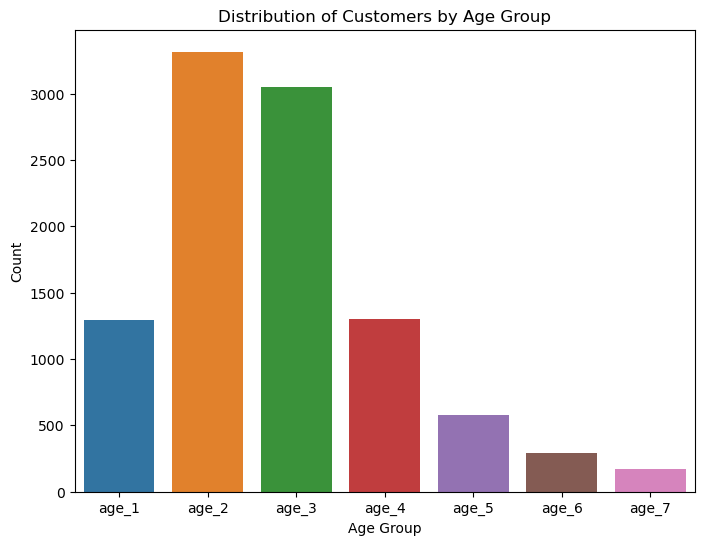

In [36]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age_group', data=df_eda)
plt.title('Distribution of Customers by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

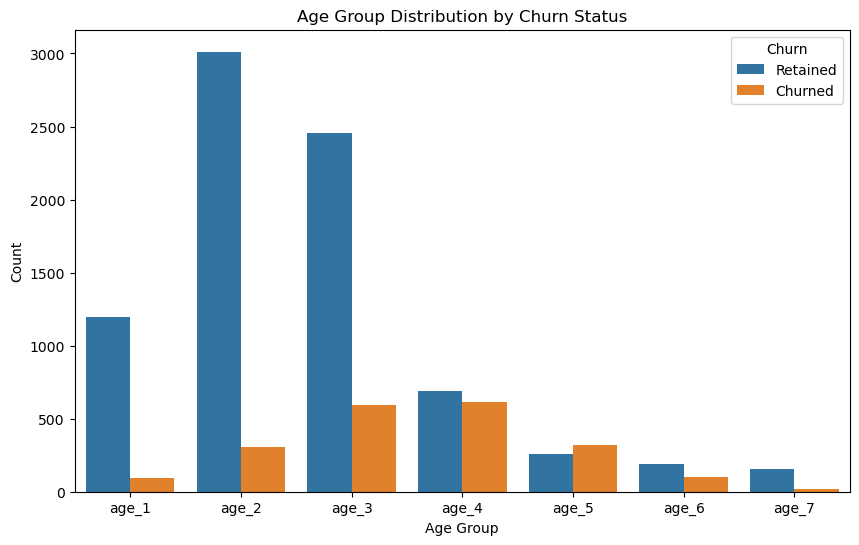

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='churn', data=df_eda)
plt.title('Age Group Distribution by Churn Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Retained', 'Churned'])
plt.show()

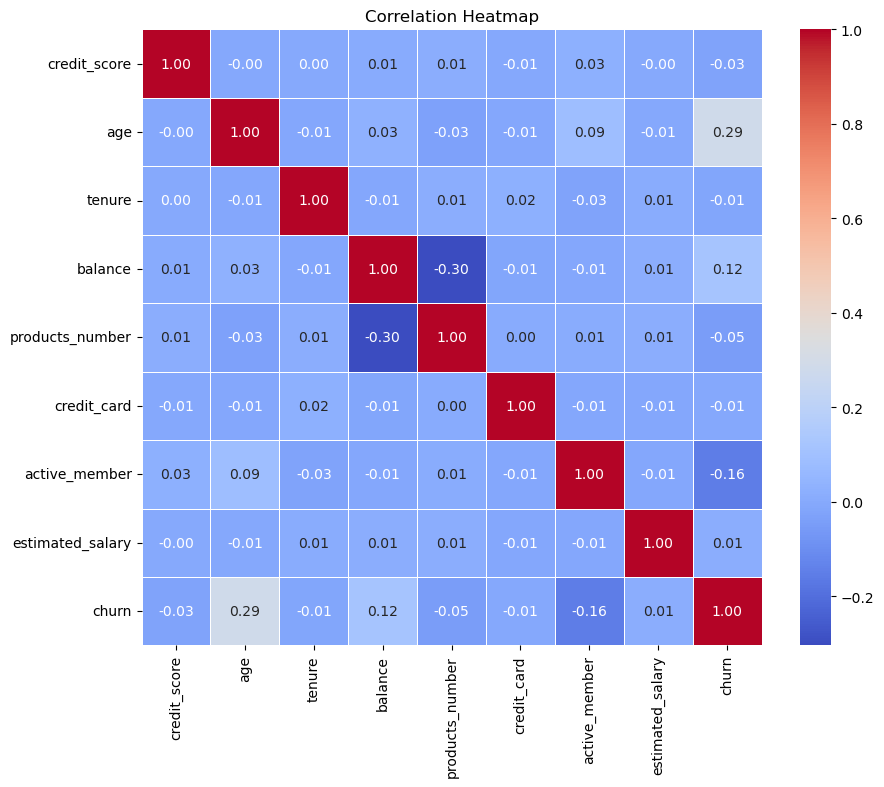

In [38]:
corr_matrix = df_eda[["credit_score","age","tenure","balance","products_number","credit_card","active_member","estimated_salary",
                         "churn"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

###  MODEL CREATION 

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold

In [40]:
df_model=df.copy()

In [41]:
df_model.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [42]:
X = df_model.drop(['churn'], axis = 1)
y = df_model['churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [43]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15601116,686,France,Male,32,6,0.00,2,1,1,179093.26
15766374,632,Germany,Male,42,4,119624.60,2,1,1,195978.86
15716994,559,Spain,Male,24,3,114739.92,1,1,0,85891.02
15730759,561,France,Female,27,9,135637.00,1,1,0,153080.40
15797900,517,France,Male,56,9,142147.32,1,0,0,39488.04


### Feature engineering

In [44]:
label_gender = LabelEncoder()
X_train['gender_encoded'] = label_gender.fit_transform(X_train['gender'])
X_test['gender_encoded'] = label_gender.fit_transform(X_test['gender'])



In [45]:
encoded_country = pd.get_dummies(X_train['country'], prefix='country', dtype=int)  
X_train = pd.concat([X_train, encoded_country], axis=1)
encoded_country = pd.get_dummies(X_test['country'], prefix='country', dtype=int)  
X_test = pd.concat([X_test, encoded_country], axis=1)

In [46]:
bin_edges = [-1, 0, float('inf')] 
bin_labels = [0, 1]  
X_train['service_type'] = pd.cut(X_train['balance'], bins=bin_edges, labels=bin_labels)
X_test['service_type'] = pd.cut(X_test['balance'], bins=bin_edges, labels=bin_labels)

In [47]:
X_test.isnull().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
gender_encoded      0
country_France      0
country_Germany     0
country_Spain       0
service_type        0
dtype: int64

In [48]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,gender_encoded,country_France,country_Germany,country_Spain,service_type
customer_id,,,,,,,,,,,,,,,
15601116,686,France,Male,32,6,0.00,2,1,1,179093.26,1,1,0,0,0
15766374,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,1,0,1,0,1
15716994,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1,0,0,1,1
15730759,561,France,Female,27,9,135637.00,1,1,0,153080.40,0,1,0,0,1
15797900,517,France,Male,56,9,142147.32,1,0,0,39488.04,1,1,0,0,1


In [49]:
bins = [X_train['age'].min(), 28,36,44,52,60,68,X_train['age'].max()]
labels = ['age_1','age_2','age_3','age_4','age_5','age_6','age_7']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels,include_lowest=True)


In [50]:
bins = [X_test['age'].min(), 28,36,44,52,60,68,X_test['age'].max()]
labels = ['age_1','age_2','age_3','age_4','age_5','age_6','age_7']

X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels,include_lowest=True)

In [51]:
encoded_age = pd.get_dummies(X_train['age_group'], prefix='age', dtype=int)  
X_train = pd.concat([X_train, encoded_age], axis=1)


In [52]:
encoded_age = pd.get_dummies(X_test['age_group'], prefix='age', dtype=int)  
X_test = pd.concat([X_test, encoded_age], axis=1)


In [53]:
X_train['age_products_interaction'] = X_train['age'] * X_train['products_number']
X_test['age_products_interaction'] = X_test['age'] * X_test['products_number']


In [54]:
bins = [X_train['credit_score'].min(), 450,550,650,750,X_train['credit_score'].max()]
labels = ['cred_1','cred_2','cred_3','cred_4','cred_5']
X_train['cred_group'] = pd.cut(X_train['credit_score'], bins=bins, labels=labels,include_lowest=True)



In [55]:
bins = [X_test['credit_score'].min(), 450,550,650,750,X_test['credit_score'].max()]
labels = ['cred_1','cred_2','cred_3','cred_4','cred_5']
X_test['cred_group'] = pd.cut(X_test['credit_score'], bins=bins, labels=labels,include_lowest=True)



In [56]:
encoded_cred = pd.get_dummies(X_train['cred_group'], prefix='cred', dtype=int)  
X_train = pd.concat([X_train, encoded_cred], axis=1)



In [57]:
encoded_cred = pd.get_dummies(X_test['cred_group'], prefix='cred', dtype=int)  
X_test = pd.concat([X_test, encoded_cred], axis=1)



In [58]:
products_number_freq = X_train['products_number'].value_counts().to_dict()
products_number_freq_test = X_test['products_number'].value_counts().to_dict()


In [59]:
X_train['products_number_frequency'] = X_train['products_number'].map(products_number_freq)
X_test['products_number_frequency'] = X_test['products_number'].map(products_number_freq_test)


In [60]:
X_train['tenure_age_ratio'] = X_train['tenure'] / X_train['age']
X_test['tenure_age_ratio'] = X_test['tenure'] / X_test['age']


In [61]:
X_train['mean_balance_by_country'] = X_train.groupby('country')['balance'].transform('mean')
X_test['mean_balance_by_country'] = X_test.groupby('country')['balance'].transform('mean')



In [62]:
X_train.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'gender_encoded', 'country_France', 'country_Germany', 'country_Spain',
       'service_type', 'age_group', 'age_age_1', 'age_age_2', 'age_age_3',
       'age_age_4', 'age_age_5', 'age_age_6', 'age_age_7',
       'age_products_interaction', 'cred_group', 'cred_cred_1', 'cred_cred_2',
       'cred_cred_3', 'cred_cred_4', 'cred_cred_5',
       'products_number_frequency', 'tenure_age_ratio',
       'mean_balance_by_country'],
      dtype='object')

In [63]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,age_products_interaction,cred_group,cred_cred_1,cred_cred_2,cred_cred_3,cred_cred_4,cred_cred_5,products_number_frequency,tenure_age_ratio,mean_balance_by_country
customer_id,,,,,,,,,,,,,,,,,,,,,
15601116,686,France,Male,32,6,0.00,2,1,1,179093.26,...,64,cred_4,0,0,0,1,0,3690,0.187500,61556.960826
15766374,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,...,84,cred_3,0,0,1,0,0,3690,0.095238,120045.337374
15716994,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,...,24,cred_3,0,0,1,0,0,4052,0.125000,60926.036170
15730759,561,France,Female,27,9,135637.00,1,1,0,153080.40,...,27,cred_3,0,0,1,0,0,4052,0.333333,61556.960826
15797900,517,France,Male,56,9,142147.32,1,0,0,39488.04,...,56,cred_2,0,1,0,0,0,4052,0.160714,61556.960826


In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
columns_to_scale = ["credit_score","age","balance","estimated_salary","age_products_interaction",'products_number_frequency',
                  'mean_balance_by_country']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

In [66]:
X_test.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,age_products_interaction,cred_group,cred_cred_1,cred_cred_2,cred_cred_3,cred_cred_4,cred_cred_5,products_number_frequency,tenure_age_ratio,mean_balance_by_country
customer_id,,,,,,,,,,,,,,,,,,,,,
15687492,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,...,64,cred_3,0,0,1,0,0,900,0.093750,118457.204659
15736963,623,France,Male,43,1,0.00,2,1,1,146379.30,...,86,cred_3,0,0,1,0,0,900,0.023256,64190.174461
15721730,601,Spain,Female,44,4,0.00,2,1,0,58561.31,...,88,cred_3,0,0,1,0,0,900,0.090909,65510.601349
15762134,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,...,118,cred_2,0,1,0,0,0,900,0.135593,118457.204659
15648898,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,...,27,cred_3,0,0,1,0,0,1032,0.259259,65510.601349


In [67]:
columns_to_scale = ["credit_score","age","balance","estimated_salary","age_products_interaction",'products_number_frequency',
                  'mean_balance_by_country']
scaler = StandardScaler()
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

In [68]:
#columns_to_scale_test = ["credit_score","age","balance","estimated_salary"]
#scaler = StandardScaler()
#X_test[columns_to_scale_test] = scaler.fit_transform(X_test[columns_to_scale_test])

In [69]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,age_products_interaction,cred_group,cred_cred_1,cred_cred_2,cred_cred_3,cred_cred_4,cred_cred_5,products_number_frequency,tenure_age_ratio,mean_balance_by_country
customer_id,,,,,,,,,,,,,,,,,,,,,
15601116,0.356500,France,Male,-0.655786,6,-1.218471,2,1,1,1.367670,...,0.162705,cred_4,0,0,0,1,0,-0.103834,0.187500,-0.571184
15766374,-0.203898,Germany,Male,0.294938,4,0.696838,2,1,1,1.661254,...,0.864097,cred_3,0,0,1,0,0,-0.103834,0.095238,1.725635
15716994,-0.961472,Spain,Male,-1.416365,3,0.618629,1,1,0,-0.252807,...,-1.240078,cred_3,0,0,1,0,0,0.431039,0.125000,-0.595961
15730759,-0.940717,France,Female,-1.131148,9,0.953212,1,1,0,0.915393,...,-1.134869,cred_3,0,0,1,0,0,0.431039,0.333333,-0.571184
15797900,-1.397337,France,Male,1.625953,9,1.057449,1,0,0,-1.059600,...,-0.117851,cred_2,0,1,0,0,0,0.431039,0.160714,-0.571184


### Dropping categorical variables

In [70]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ["credit_score","age","balance","estimated_salary",
                    "age_products_interaction",'products_number_frequency',
                  'mean_balance_by_country']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_train.drop(columns=['gender','age_group','cred_group','country'],inplace=True)
X_test.drop(columns=['gender','age_group','cred_group','country'],inplace=True)

X_train["service_type"]=X_train["service_type"].astype('int')
X_test["service_type"]=X_test["service_type"].astype('int')

In [74]:
X_train["service_type"]=X_train["service_type"].astype('int')
X_test["service_type"]=X_test["service_type"].astype('int')


In [75]:
X_test.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,gender_encoded,country_France,...,age_age_7,age_products_interaction,cred_cred_1,cred_cred_2,cred_cred_3,cred_cred_4,cred_cred_5,products_number_frequency,tenure_age_ratio,mean_balance_by_country
customer_id,,,,,,,,,,,,,,,,,,,,,
15687492,-0.512502,-0.677299,3,0.300846,2,0,0,-0.990969,1,0,...,0,0.158089,0,0,1,0,0,-0.216985,0.093750,1.736225
15736963,-0.236047,0.384298,1,-1.255997,2,1,1,0.829379,1,1,...,0,0.916310,0,0,1,0,0,-0.216985,0.023256,-0.593853
15721730,-0.461306,0.480807,4,-1.255997,2,1,0,-0.699045,0,0,...,0,0.985239,0,0,1,0,0,-0.216985,0.090909,-0.537158
15762134,-1.434019,1.928440,8,0.662139,2,1,1,1.252315,1,0,...,0,2.019176,0,1,0,0,0,-0.216985,0.135593,1.736225
15648898,-0.881109,-1.159844,7,0.756215,1,1,1,0.277492,0,0,...,0,-1.117100,0,0,1,0,0,0.516880,0.259259,-0.537158


In [76]:
X_train.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'gender_encoded',
       'country_France', 'country_Germany', 'country_Spain', 'service_type',
       'age_age_1', 'age_age_2', 'age_age_3', 'age_age_4', 'age_age_5',
       'age_age_6', 'age_age_7', 'age_products_interaction', 'cred_cred_1',
       'cred_cred_2', 'cred_cred_3', 'cred_cred_4', 'cred_cred_5',
       'products_number_frequency', 'tenure_age_ratio',
       'mean_balance_by_country'],
      dtype='object')

In [77]:
X_train.drop(columns=['country_France','country_Spain',"age_age_1","age_age_2",
                     'age_age_3','age_age_6','age_age_7','cred_cred_1','cred_cred_2','cred_cred_3','cred_cred_4','cred_cred_5',
                     'products_number_frequency','tenure_age_ratio','mean_balance_by_country'],inplace=True)
X_test.drop(columns=['country_France','country_Spain',"age_age_1","age_age_2",
                     'age_age_3','age_age_6','age_age_7','cred_cred_1','cred_cred_2','cred_cred_3','cred_cred_4','cred_cred_5',
                     'products_number_frequency','tenure_age_ratio','mean_balance_by_country'],inplace=True)

In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report
import numpy as np


xgboost = XGBClassifier(learning_rate=0.1, max_depth=3, scale_pos_weight=0.55,
                         objective='binary:logistic', n_estimators=100)
xgboost.fit(X_train, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
feature_importance = xgboost.feature_importances_
for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")

credit_score: 0.0155
age: 0.1883
tenure: 0.0188
balance: 0.0398
products_number: 0.1956
credit_card: 0.0081
active_member: 0.1617
estimated_salary: 0.0138
gender_encoded: 0.0449
country_Germany: 0.0790
service_type: 0.0924
age_age_4: 0.0570
age_age_5: 0.0200
age_products_interaction: 0.0652


### For traning set.

In [80]:
y_pred = xgboost.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
report = classification_report(y_train, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.864875
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      6356
           1       0.90      0.39      0.54      1644

    accuracy                           0.86      8000
   macro avg       0.88      0.69      0.73      8000
weighted avg       0.87      0.86      0.84      8000



### For test.

In [113]:
y_predict = xgboost.predict(X_test)
xg_accuracy = accuracy_score(y_test, y_predict)
report = classification_report(y_test, y_predict)
print("Accuracy:", xg_accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8605
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      1607
           1       0.86      0.35      0.49       393

    accuracy                           0.86      2000
   macro avg       0.86      0.67      0.71      2000
weighted avg       0.86      0.86      0.84      2000



### There is no overfit

In [86]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

[[1585   22]
 [ 257  136]]


(<Figure size 1200x500 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

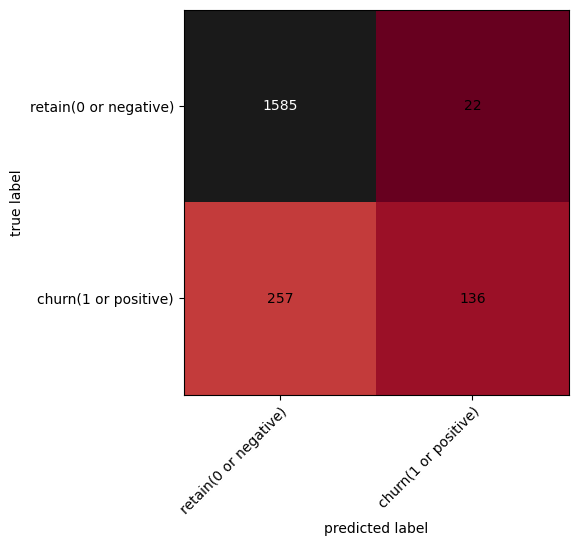

In [87]:
conf_matrix=confusion_matrix(y_test,y_predict)
print(conf_matrix)
plot_confusion_matrix(conf_matrix,class_names=["retain(0 or negative)","churn(1 or positive)"],figsize=(12,5),cmap= plt.cm.RdGy)

## Logistic regression

In [88]:
models = {"Logistic Regression": LogisticRegression(),
          "Random Forest": RandomForestClassifier(),
        "model_NB": GaussianNB()}
 
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)#evaluation accurcy of each model test data(accuracy_score(y_test,y_pred))
    return model_scores

model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Logistic Regression': 0.84, 'Random Forest': 0.868, 'model_NB': 0.806}

## KNN

In [89]:
model = {"KNN": KNeighborsClassifier()}
 
knn_model_scores = fit_and_score(models=model,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
knn_model_scores

{'KNN': 0.851}

In [90]:
train_scores = []
test_scores = []

neighbors = range(1, 21)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [91]:
max_test_score_knn= max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score_knn]
print('Max test score {} % and k = {}'.format(max_test_score_knn*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 85.75 % and k = [19]


## Logistic regression with random search

In [93]:
np.random.seed(42)
log_reg_grid = {'C': np.logspace(-4, 4, 20),
                'solver':['liblinear']}
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv = 5,
                                n_iter = 20,
                                verbose = True)

rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [94]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1.623776739188721}

In [96]:
rs_log_reg.score(X_test, y_test)

0.8405

## Grid Search

In [97]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-10, 10, 20),
    'solver' : ['liblinear'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

grid_log_reg= GridSearchCV(LogisticRegression(), 
                               param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

grid_log_reg.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10]),
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear']}],
             verbose=True)

In [98]:
grid_log_reg.best_params_

{'C': 37.92690190732238,
 'max_iter': 5000,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [100]:
logistic_regresion_result=grid_log_reg.score(X_test, y_test)
logistic_regresion_result

0.8385

## For RandomForestClassifier

## RandomizedSearchCV

In [102]:
np.random.seed(42)
rf_grid = {
    'n_estimators': np.arange(100, 1500, 100),
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': np.arange(2, 50, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': ["auto", "sqrt", "log2", None],
    'max_samples': [0.4, 0.6, 0.8, 1.0]  # Assuming your dataset is large enough for 1.0
}

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'max_samples': [0.4, 0.6, 0.8, 1.0],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400])},
                   verbose=True)

In [103]:
rs_rf.best_params_

{'n_estimators': 1100,
 'min_samples_split': 32,
 'min_samples_leaf': 5,
 'max_samples': 1.0,
 'max_features': 'sqrt',
 'max_depth': 10}

In [104]:
rs_rf=rs_rf.score(X_test, y_test)
rs_rf

0.862

## GridSearchCV

In [105]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}
rf_classifier = RandomForestClassifier()

random_forest_result = GridSearchCV(estimator=rf_classifier, 
                       param_grid=param_grid, 
                       cv=5,  
                       verbose=True,  
                       n_jobs=-1)  

random_forest_result.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=True)

In [106]:
random_forest_result.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [107]:
random_forest_result=random_forest_result.score(X_test, y_test)
random_forest_result

0.8645

## For Naive Bayes

## GridSearchCV

In [116]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

NB_grid = GridSearchCV(estimator=GaussianNB(), 
                       param_grid=param_grid_nb, 
                       verbose=1,
                       cv=10, 
                       n_jobs=-1)
NB_grid.fit(X_train, y_train)
print(NB_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.01519911082952933)


In [120]:
preds_NB = NB_grid.best_estimator_.predict(X_test)

In [121]:
NB_result

0.8315

## Compare All results

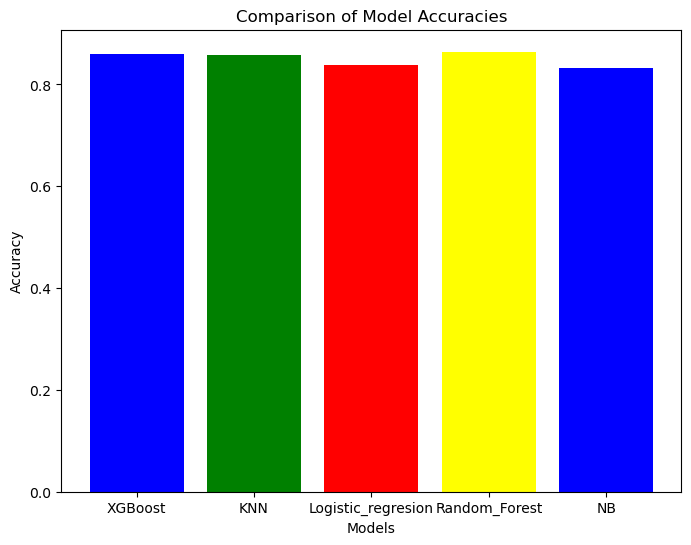

In [115]:
import matplotlib.pyplot as plt

accuracies = [xg_accuracy, max_test_score_knn, logistic_regresion_result, random_forest_result,NB_result]
labels = ['XGBoost', 'KNN', 'Logistic_regresion', 'Random_Forest','NB'] 

# Plot
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green', 'red','yellow'])
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()